In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Optimal Portfolio Construction** 
 **Using Monte-Carlo Method**

In [140]:
month_ret = pd.read_excel('monthly_returns.xlsx')
month_ret.head()

,Date,INFY Chg%,RELI Chg%,SBI Chg%,ITC Chg%,ASOK Chg%,TITN Chg%,ASPN Chg%,CIPL Chg%,LART Chg%,HAPL Chg%,BLDT Chg%,PVR Chg%
0,2023-02-01 00:00:00,-0.0301,-0.0133,-0.0555,0.0056,-0.0268,-0.0018,0.0378,-0.1096,-0.0072,0.0127,-0.0167,-0.1077
1,2023-01-01 00:00:00,0.0169,-0.0759,-0.0981,0.0691,0.0425,-0.0848,-0.1172,-0.0539,0.0185,-0.0187,-0.1804,-0.0108
2,2022-12-01 00:00:00,-0.0775,-0.0674,0.0187,0.0627,-0.0363,-0.0209,-0.0275,-0.0559,0.0053,0.0441,0.0134,-0.0708
3,2022-11-01 00:00:00,0.0633,0.0713,0.0499,-0.0249,-0.0294,-0.0393,0.0217,-0.0238,0.0256,-0.0731,0.0023,0.0425
4,2022-10-01 00:00:00,0.0879,0.0723,0.0814,-0.0249,0.0043,0.0593,-0.0702,0.0470,0.0949,-0.0865,-0.1428,-0.0089


In [141]:
Rf_data = pd.read_excel('RmRf_data.xlsx', 'Rm-rf-data-monthly-1993-2022')
Rf_data.head()

,Date,Rm (%),Rf(%)
0,2022-12,-0.039768,0.005074
1,2022-11,0.023095,0.005074
2,2022-10,0.018024,0.005163
3,2022-09,-0.035792,0.004749
4,2022-08,0.048899,0.004772


In [142]:
# print(month_ret.shape)
# N = int(input("Enter No. of months to average(max 82): "))
N = 50      # No. of months to average for
month_ret = month_ret.iloc[:N, :]

port_size = month_ret.shape[1]-1

In [143]:
avg_ret = month_ret.mean(axis=0,numeric_only=1)
print(avg_ret.shape)
covMat = month_ret.cov(numeric_only=1)

Rf = Rf_data.iloc[:N,-1]
avg_rf = Rf.mean(numeric_only=1)

# print(avg_ret, avg_rf)

(12,)


In [144]:
##### creating samples for Monte-Carlo method
iter = 35000     # No. of samples for MC
# amount = 1      # Amount to be invested
# # No Capital Rationing

wt = np.random.random_sample((iter,port_size))
wt_sum = np.sum(wt, axis=1)
wt_sum = np.reshape(wt_sum, (wt_sum.size,1))
print(wt.shape, wt_sum.shape)
weights = np.divide(wt, wt_sum)
# print(wt[:4,:],'\n',wt_sum,'\n',weights[:4,:])

(35000, 12) (35000, 1)


(array([5537., 5848., 6254., 6538., 6356., 3278.,  946.,  202.,   32.,
           9.]),
 array([1.69948298e-06, 2.80958715e-02, 5.61900435e-02, 8.42842155e-02,
        1.12378388e-01, 1.40472560e-01, 1.68566732e-01, 1.96660904e-01,
        2.24755076e-01, 2.52849248e-01, 2.80943420e-01]),
 <BarContainer object of 10 artists>)

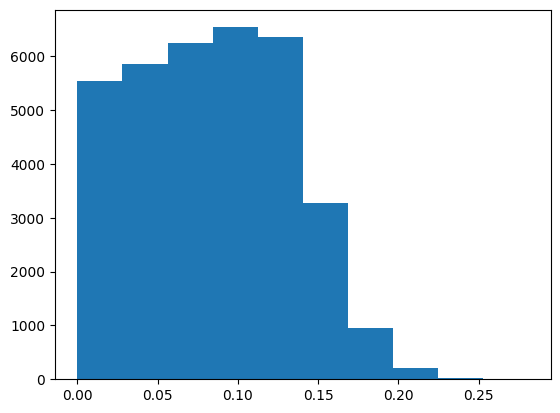

In [145]:
plt.hist(weights[:,0])


In [146]:
wt_sum


array([[5.66660397],
       [5.38987174],
       [5.44076329],
       ...,
       [6.55869458],
       [6.6521079 ],
       [5.19262559]])

In [147]:
###### Expected return, risk calculation
port_ret    = []
port_risk   = []
port_sharpe = []
for i in range(iter):
    ret = weights[i,:] @ avg_ret
    var =  weights[i,:] @ covMat @ weights[i,:]
    risk = np.sqrt(var) 
    ratio = (ret - avg_rf)/risk

    port_ret.append(ret)
    port_risk.append(risk)
    port_sharpe.append(ratio)
    
# print(len(port_ret), len(port_risk))
sharpe_ind = port_sharpe.index(max(port_sharpe))
minvar_ind = port_risk.index(min(port_risk))
maxret_ind = port_ret.index(max(port_ret))
print(f'Portfolio with Max. Sharpe Ratio : \n Return: {port_ret[sharpe_ind]} \n\
      Risk: {port_risk[sharpe_ind]} \n Stock Proportion: {weights[sharpe_ind, :]} ')

print(f'\nPortfolio with Min Risk : \n Return: {port_ret[minvar_ind]} \n\
      Risk: {port_risk[minvar_ind]} \n Stock Proportion: {weights[minvar_ind, :]}')


Portfolio with Max. Sharpe Ratio : 
 Return: 0.017448828035310344 
      Risk: 0.049487313261404015 
 Stock Proportion: [0.25302991 0.08820314 0.06057611 0.11784275 0.03463836 0.09747387
 0.11470221 0.04708379 0.01718329 0.10400913 0.05966978 0.00558765] 

Portfolio with Min Risk : 
 Return: 0.015333318000963944 
      Risk: 0.04205604280885938 
 Stock Proportion: [0.15985359 0.05220461 0.07628362 0.24103471 0.02964932 0.03398557
 0.14811079 0.10019617 0.02428028 0.05945747 0.05482272 0.02012115]


In [148]:
#### Interpolate Efficient frontier


Find Market cap weighted portfolio, given user risk/ret cal. other quantity


 **Using Quadratic-Programming Method**

In [149]:
import cvxpy as cp

## Problem Setup
w = cp.Variable(port_size)
mu = avg_ret.to_numpy()
mu = np.reshape(mu, (mu.size,1))
gamma = cp.Parameter(nonneg=True)   #risk-aversion parameter  
ret = mu.T @ w
risk = cp.quad_form(w, covMat)
prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w>=0])


In [150]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value



Text(0, 0.5, 'Return')

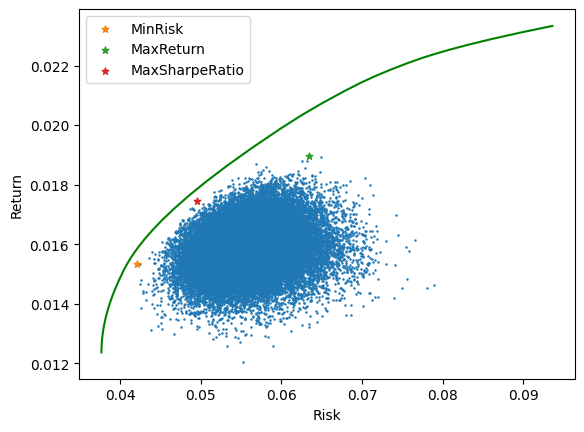

In [151]:
plt.plot(risk_data, ret_data, "g-")

plt.scatter(port_risk, port_ret, s=0.6)
# plt.scatter(0,avg_rf,s=25, marker='*', label='RiskFree')
plt.scatter(port_risk[minvar_ind],port_ret[minvar_ind],s=25, marker='*', label='MinRisk')
plt.scatter(port_risk[maxret_ind],port_ret[maxret_ind],s=25, marker='*', label='MaxReturn')
plt.scatter(port_risk[sharpe_ind],port_ret[sharpe_ind],s=25, marker='*', label='MaxSharpeRatio')
plt.legend()

plt.xlabel("Risk")
plt.ylabel("Return")